In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_california_housing
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

In [4]:
# Load California Housing dataset
california_data = fetch_california_housing(as_frame=True)
cali_df = california_data.frame
# Display column names
print("California Housing dataset columns:", cali_df.columns)

# Prepare data for regression
X_reg = cali_df.drop('MedHouseVal', axis=1)  # Correct target column
y_reg = cali_df['MedHouseVal']

# Load Titanic dataset
titanic_df = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')
titanic_df = titanic_df[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']]
titanic_df.dropna(inplace=True)

California Housing dataset columns: Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'MedHouseVal'],
      dtype='object')


In [5]:
# Prepare data for classification
X_class = titanic_df.drop('Survived', axis=1)
y_class = titanic_df['Survived']

# Preprocessing for regression
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_reg_train = scaler.fit_transform(X_reg_train)
X_reg_test = scaler.transform(X_reg_test)

In [6]:
# Preprocessing for classification with ColumnTransformer
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(X_class, y_class, test_size=0.2, random_state=42)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Age', 'SibSp', 'Parch', 'Fare']),
        ('cat', OneHotEncoder(), ['Pclass', 'Sex'])
    ]
)
X_class_train = preprocessor.fit_transform(X_class_train)
X_class_test = preprocessor.transform(X_class_test)

In [15]:
# Function to create ANN model
def create_ann_model(input_shape, output_units, regularizer=None):
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_shape,)))  # Use layers.Input with shape
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizer))
    model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizer))
    model.add(layers.Dense(output_units, activation='sigmoid' if output_units == 1 else 'linear')) 
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy' if output_units == 1 else 'mean_squared_error', 
                  metrics=['accuracy'] if output_units == 1 else ['mae'])
    return model

In [8]:
# Function to train classification models
def train_classification_models(X_train, y_train, X_test, y_test):
    regularization_types = {
        'None': None,
        'L1': regularizers.l1(0.01),
        'L2': regularizers.l2(0.01),
        'Dropout': 'dropout',
    }
    
    results = {}
    for reg_type, reg in regularization_types.items():
        model = create_ann_model(X_train.shape[1], 1, regularizer=reg if reg != 'dropout' else None)
        if reg == 'dropout':
            model.add(layers.Dropout(0.5))
        early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[early_stopping], verbose=0)
        
        results[reg_type] = history
    return results


In [9]:
# Function to train regression models
def train_regression_models(X_train, y_train, X_test, y_test):
    regularization_types = {
        'None': None,
        'L1': regularizers.l1(0.01),
        'L2': regularizers.l2(0.01),
        'Dropout': 'dropout',
    }
    
    results = {}
    
    for reg_type, reg in regularization_types.items():
        model = create_ann_model(X_train.shape[1], 1, regularizer=reg if reg != 'dropout' else None)
        if reg == 'dropout':
            model.add(layers.Dropout(0.5))
        early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[early_stopping], verbose=0)
        
        results[reg_type] = history
    return results


In [10]:
# Plotting functions for accuracy and loss
def plot_accuracy(results, title):
    plt.figure(figsize=(12, 6))
    for reg_type, history in results.items():
        plt.plot(history.history['accuracy'], label=f'{reg_type} Train')
        plt.plot(history.history['val_accuracy'], label=f'{reg_type} Val')
    
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

In [11]:
def plot_loss(results, title):
    plt.figure(figsize=(12, 6))
    for reg_type, history in results.items():
        plt.plot(history.history['loss'], label=f'{reg_type} Train')
        plt.plot(history.history['val_loss'], label=f'{reg_type} Val')
    
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()


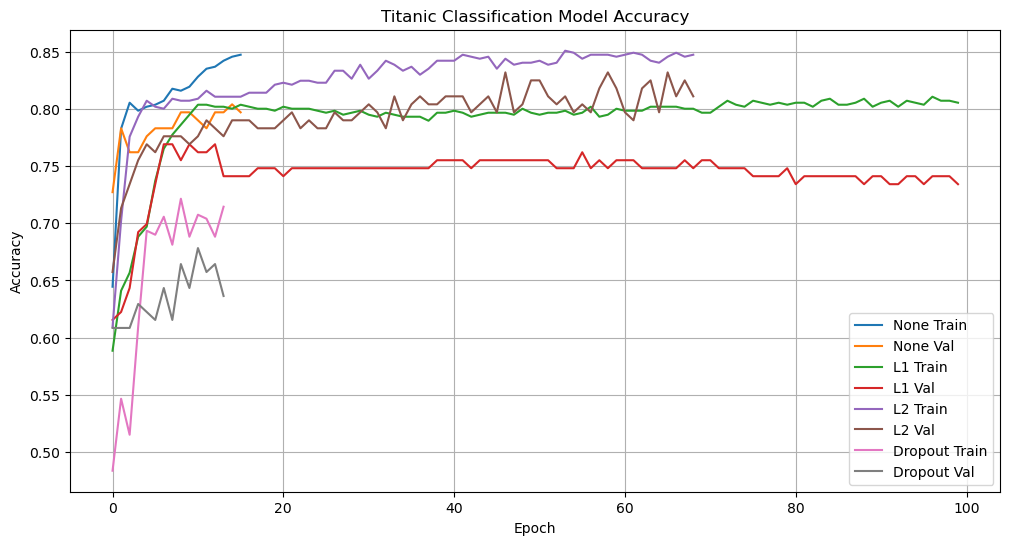

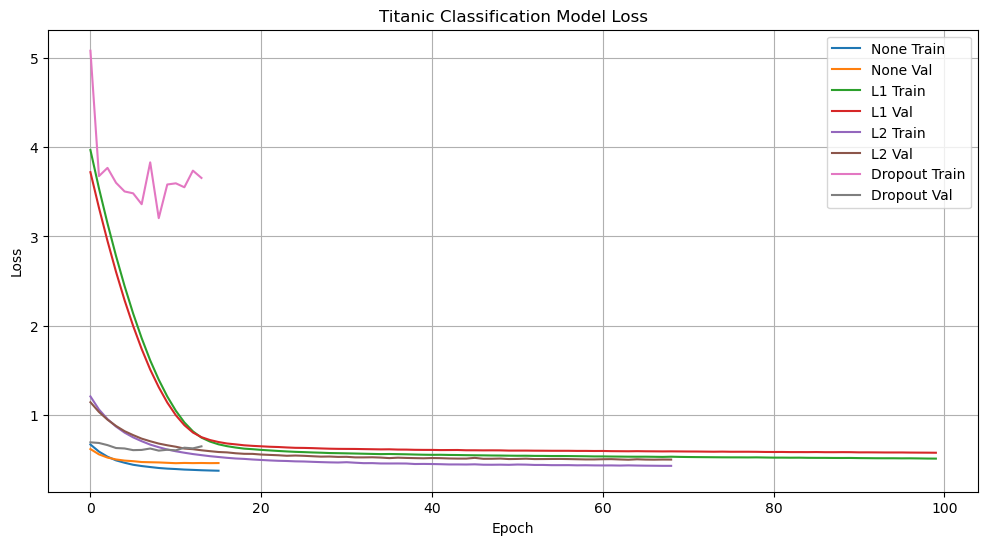

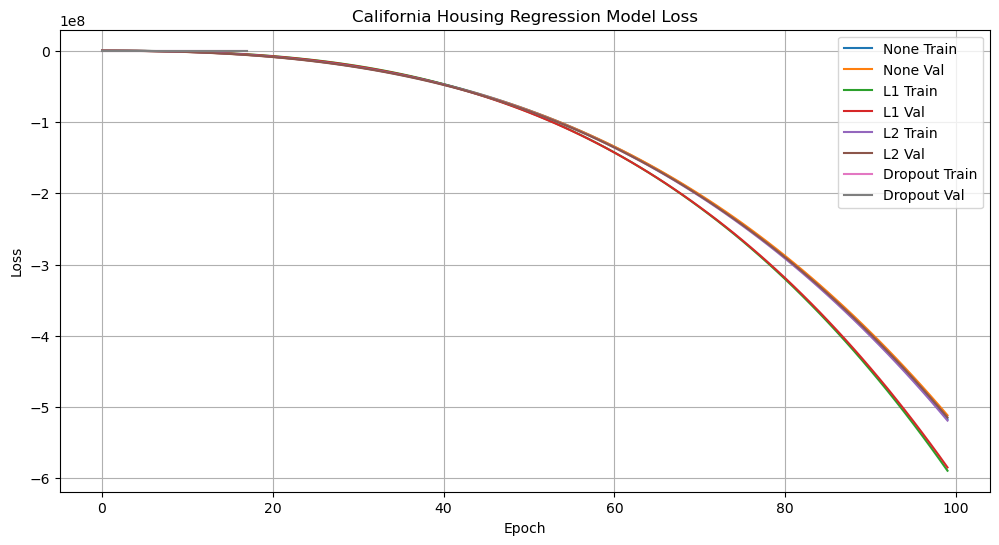

In [16]:
# Train and visualize models
# Train classification models
classification_results = train_classification_models(X_class_train, y_class_train, X_class_test, y_class_test)

# Plot Accuracy and Loss for Classification
plot_accuracy(classification_results, "Titanic Classification Model Accuracy")
plot_loss(classification_results, "Titanic Classification Model Loss")

# Train regression models
regression_results = train_regression_models(X_reg_train, y_reg_train, X_reg_test, y_reg_test)

# Plot Loss for Regression
plot_loss(regression_results, "California Housing Regression Model Loss")

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step


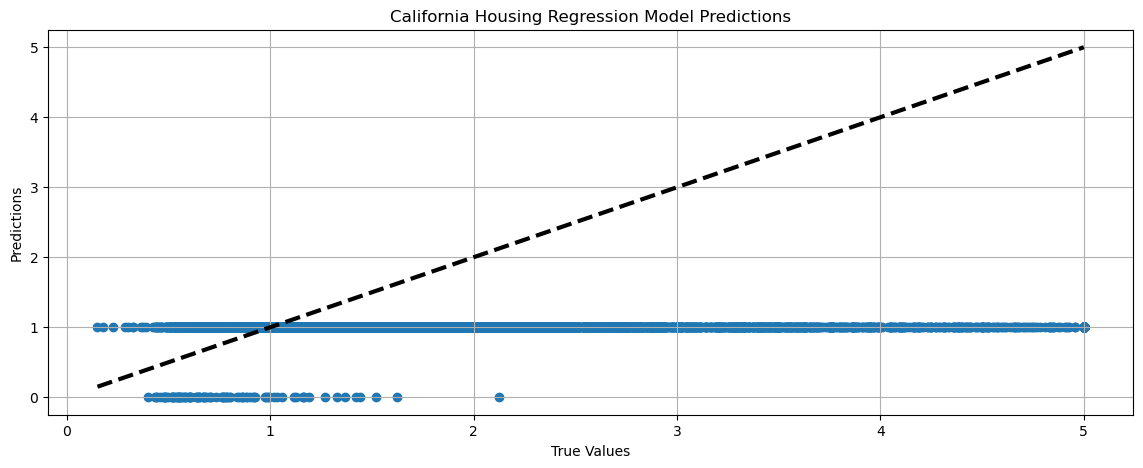

Regression MAE: 1.1509115310077518
Regression MSE: 2.436056305236918
Regression R^2: -0.8590045899312244


In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Plot performance metrics for regression
def plot_regression_metrics(y_test, preds, title):
    plt.figure(figsize=(14, 5))
    plt.scatter(y_test, preds)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)  # Diagonal line
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.grid()
    plt.savefig('regression_metrics.png')
    plt.show()
# Function to train regression models
def train_regression_model(X_train, y_train, X_test, y_test):
    model = create_ann_model(X_train.shape[1], 1)  # Regression output has 1 unit
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, verbose=0)
    pred = model.predict(X_test)
    
    # Calculate regression metrics
    mae = mean_absolute_error(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    
    return pred, mae, mse, r2
regression_predictions, mae, mse, r2 = train_regression_model(X_reg_train, y_reg_train, X_reg_test, y_reg_test)

plot_regression_metrics(y_reg_test, regression_predictions, "California Housing Regression Model Predictions")

# Print regression metrics
print(f'Regression MAE: {mae}')
print(f'Regression MSE: {mse}')
print(f'Regression R^2: {r2}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/stepWARNING:tensorflow:5 out of the last 139 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000235C2A28680> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Classification Metrics for None:
Confusion Matrix:
 [[74 13]
 [15 41]]
Classificati

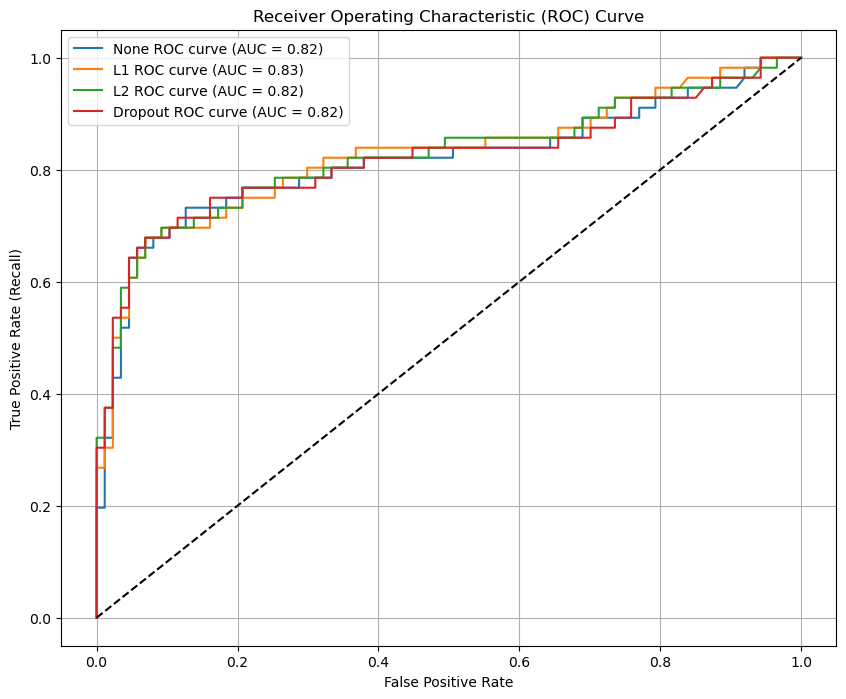

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Function to evaluate classification models
def evaluate_classification_models(results, X_test, y_test):
    evaluations = {}
    for reg_type, history in results.items():
        model = create_ann_model(X_class_train.shape[1], 1, regularizer=None)  # No regularization when evaluating
        model.fit(X_class_train, y_class_train, epochs=100, batch_size=32, verbose=0)
        
        y_pred_prob = model.predict(X_test).flatten()  # Get predicted probabilities
        y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

        # Store evaluation metrics
        evaluations[reg_type] = {
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'classification_report': classification_report(y_test, y_pred, output_dict=True),
            'y_pred_prob': y_pred_prob
        }
        
        # Calculate ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
        auc_value = auc(fpr, tpr)

        # Store AUC value and ROC curve data
        evaluations[reg_type]['roc_auc'] = auc_value
        evaluations[reg_type]['fpr'] = fpr
        evaluations[reg_type]['tpr'] = tpr
    return evaluations

# Evaluate classification models
classification_evaluations = evaluate_classification_models(classification_results, X_class_test, y_class_test)

# Function to plot ROC curves
def plot_roc_curves(evaluations):
    plt.figure(figsize=(10, 8))
    for reg_type, metrics in evaluations.items():
        plt.plot(metrics['fpr'], metrics['tpr'], label=f'{reg_type} ROC curve (AUC = {metrics["roc_auc"]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.legend()
    plt.grid()
    plt.savefig('roc_curve.png')
    plt.show()

# Print evaluation metrics and plot ROC curves
for reg_type, metrics in classification_evaluations.items():
    print(f"Classification Metrics for {reg_type}:")
    print("Confusion Matrix:\n", metrics['confusion_matrix'])
    print("Classification Report:\n", metrics['classification_report'])
    print("\n")

# Plot ROC Curves
plot_roc_curves(classification_evaluations)